## Optimization exploration
We want the thermalization to go as fast as possible.

In [1]:
using BenchmarkTools

In [2]:
function takeHalf(A::Array{Float64, 1})
    return A[1:20]
end
function takeHalf2(A::Array{Float64, 1})
    return A
end

takeHalf2 (generic function with 1 method)

In [3]:
A = rand(50)
@benchmark takeHalf(A)

BenchmarkTools.Trial: 
  memory estimate:  240 bytes
  allocs estimate:  1
  --------------
  minimum time:     52.525 ns (0.00% GC)
  median time:      59.956 ns (0.00% GC)
  mean time:        68.494 ns (8.35% GC)
  maximum time:     2.485 μs (90.42% GC)
  --------------
  samples:          10000
  evals/sample:     987

In [4]:
@benchmark takeHalf2(A)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     17.261 ns (0.00% GC)
  median time:      17.573 ns (0.00% GC)
  mean time:        17.796 ns (0.00% GC)
  maximum time:     39.233 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     998

In [5]:
@benchmark e = Array{Float64, 1}(10000)

BenchmarkTools.Trial: 
  memory estimate:  78.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     842.011 ns (66.62% GC)
  median time:      894.920 ns (66.95% GC)
  mean time:        1.156 μs (73.76% GC)
  maximum time:     119.121 μs (99.32% GC)
  --------------
  samples:          7057
  evals/sample:     611

In [6]:
@benchmark e = zeros(10000)

BenchmarkTools.Trial: 
  memory estimate:  78.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     10.421 μs (0.00% GC)
  median time:      14.339 μs (0.00% GC)
  mean time:        16.987 μs (12.97% GC)
  maximum time:     799.650 μs (90.54% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [7]:
function nArray(n::Int64)
    return [i for i = 1:n]
end
E = zeros(10000)
n = 5
for i = 1:20
    E[(i-1)*n+1:i*n] = nArray(n)
end

In [8]:
function arrayMap()
    L = 10000
    E = Array{Int64,1}(L)
    n = 5
    N = floor(Int64, L/n)
    for i = 1:N
        E[(i-1)*n+1:i*n] = nArray(n)
    end
    return E
end
function arrayMap2()
    L = 10000
    n = 5
    N = floor(Int64, L/n)
    E = nArray(n)
    for i = 2:N
        E = vcat(E, nArray(n))
    end
    return E
end
        

arrayMap2 (generic function with 1 method)

In [9]:
arrayMap2() == arrayMap()

true

In [10]:
@benchmark arrayMap()

BenchmarkTools.Trial: 
  memory estimate:  328.20 KiB
  allocs estimate:  2002
  --------------
  minimum time:     82.816 μs (0.00% GC)
  median time:      88.874 μs (0.00% GC)
  mean time:        105.282 μs (11.43% GC)
  maximum time:     1.416 ms (73.01% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [11]:
@benchmark arrayMap2()

BenchmarkTools.Trial: 
  memory estimate:  76.80 MiB
  allocs estimate:  5590
  --------------
  minimum time:     17.461 ms (12.19% GC)
  median time:      18.254 ms (15.20% GC)
  mean time:        18.473 ms (15.17% GC)
  maximum time:     89.144 ms (81.71% GC)
  --------------
  samples:          271
  evals/sample:     1

# Importing and testing parallelization thermilization

In [1]:
# Import source

cd("../Source")
@everywhere include("ChiralMC.jl")
@everywhere using ChiralMC

@everywhere include("functions_msc.jl")
@everywhere include("functions_observables.jl")
@everywhere include("functions_parallel.jl")

using Base.Test
using Plots
pyplot()
using Distributions
cd("../Notebooks/")

In [2]:
@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 64     # System length
T = 0.3   # Temperature
γ = 1.0    # Order parameter amplitud

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
println("f set to $(f)")
# Calculate inverse temperature
β = 1/T
println("β set to $(β)")

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

# Measurement parameters
M = 1000    # Number of measurements
Δt = 400  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

f set to -0.125
β set to 3.3333333333333335


In [3]:
# Make reference states and high energy states.
n_workers = nprocs()-1
ψ_ref = State(2, syst)
ψ_list = [State(1,syst) for i = 1:n_workers];

In [4]:
@time t₀, E_ref, E_w, ψ_ref, ψ_w, sim_ref, sim_w = parallelThermalization!(ψ_ref, ψ_list, syst, sim);

Number of parallel workers: 2
Increasing simulation time such that tₛ = 1001 and T = 1802
Increasing simulation time such that tₛ = 1802 and T = 3244
Worker 1 initially thermalised after 2636 steps
Worker 2 initially thermalised after 2455 steps
All workers initially thermalized after 2636 steps
Thermalization successful between T = [3245, 6244]
Worker 1: ΔE = 2.0473151226055714e-5 ± 0.008861155302747038
Worker 2: ΔE = 0.00018301141055963684 ± 0.008617047450399188


In [5]:
t₀

14164

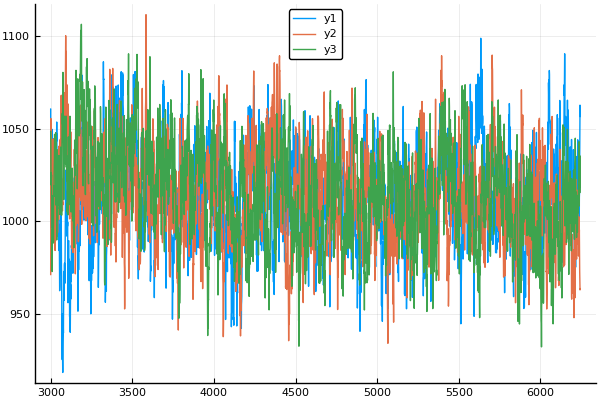

In [6]:
start = 3000
plt = plot(E_ref[start:end])
n_workers = size(E_w,1)
y = Array{Array{Float64,1},1}(n_workers+1)
y[n_workers+1] = E_ref[start:end]
for w = 1:n_workers
    y[w] = E_w[w, start:end]
end
plot(start:length(E_ref), y)

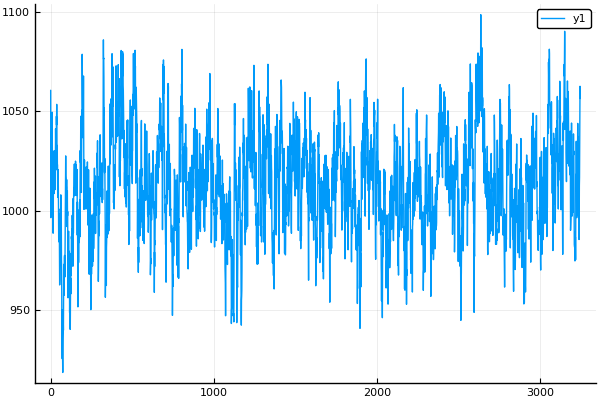

In [7]:
plot(E_w[1,start:end])

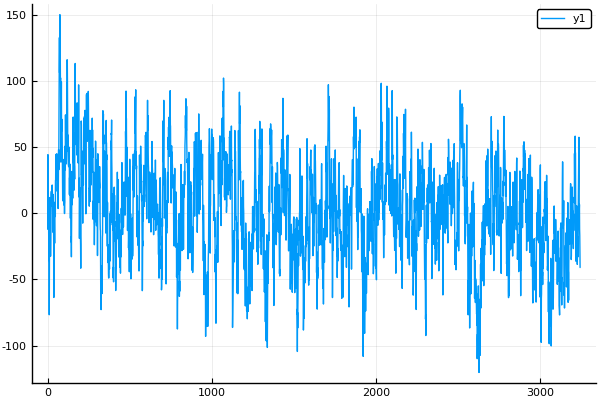

In [8]:
plot(E_ref[start:end]-E_w[1,start:end])

In [9]:
length(ψ_list)

2

In [12]:
ψ_list = vcat(ψ_list, [ψ_ref])

3-element Array{ChiralMC.State,1}:
 ChiralMC.State(ChiralMC.LatticeSite[ChiralMC.LatticeSite([2.34967, -2.72003], 4.54004, 3.37507, 0.0831356, 0.996538) ChiralMC.LatticeSite([2.39354, -4.20492], 4.94222, 2.04868, 0.985548, 0.169398) … ChiralMC.LatticeSite([-4.5993, 0.0132414], 0.869653, 2.98539, 0.563027, 0.826438) ChiralMC.LatticeSite([2.45254, 6.28246], 1.15683, 5.99342, 0.400676, 0.91622); ChiralMC.LatticeSite([0.697175, -4.44337], 5.37867, 1.28665, 0.0443866, 0.999014) ChiralMC.LatticeSite([-1.59261, -2.84413], 5.92188, 0.690999, 0.992193, 0.12471) … ChiralMC.LatticeSite([-1.61029, -0.476676], 5.59946, 4.1035, 0.970991, 0.239117) ChiralMC.LatticeSite([3.44379, -3.4141], 5.54599, 5.69554, 0.124033, 0.992278); … ; ChiralMC.LatticeSite([2.70141, 0.945776], 4.71508, 0.924269, 0.482963, 0.875641) ChiralMC.LatticeSite([3.65604, 0.525722], 2.71405, 4.33327, 0.690781, 0.723064) … ChiralMC.LatticeSite([-2.33463, 4.1161], 5.2043, 0.573872, 0.657468, 0.753483) ChiralMC.LatticeSite([3.55703, 3

In [15]:
@time av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻ = parallelSFVLA!(k_matrix, ψ_list, sim_ref, 20, t₀)

Starting 20 measurements on 3 processes doing max 7 measurements each
on a 64×64 system.
Measurement progress: 50%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Processing.

Sum of vorticity of random snapshot:
V⁺: 	-512.0000000000001
V⁻: 	-512.0

Max (S⁺, S⁻)
(1.0000000000000004, 1.000000000000001)
Max δ(S⁺, S⁻)
(0.00022051996059230323, 0.0001254054077821788)
Max correlation time
(6.835739876270975, 7.091672006548345)
1940.541155 seconds (4.48 G allocations: 148.123 GiB, 3.04% gc time)


([-0.250244 0.0444738 … 0.100032 -0.299957; -0.0425001 -0.254555 … -0.444292 -0.0485593; … ; 0.103237 -0.30358 … -0.149178 0.0576076; -0.199196 -0.15411 … -0.104699 -0.153356], [0.0795571 0.0233181 … 0.0495431 0.0884888; 0.0558441 0.0864141 … 0.0813521 0.0612255; … ; 0.0464432 0.0640627 … 0.0907073 0.0691825; 0.0410822 0.0360489 … 0.0326327 0.110333], Array{Float64,2}[[-0.00194777 -0.0094216 … 0.00854696 -1.00185; 0.0379147 1.05903 … 1.00362 -1.03314; … ; 0.0180287 0.0279479 … 0.0459308 -0.985656; 0.0203719 -0.992423 … -0.995058 -0.0082161], [0.0340593 -0.0258256 … -0.00606982 -1.00866; -0.0145021 -0.00969927 … 0.00163974 -0.0152807; … ; -0.00600949 -0.0196061 … -0.00687648 0.0260974; 0.00191471 0.00781297 … -0.000969699 0.00026184], [-0.997123 0.988357 … 0.0114251 -0.99684; -0.001357 -0.981884 … -0.987926 0.0259279; … ; -0.00605128 -0.0233173 … 0.0154246 -1.02023; -0.0342129 -0.00618269 … -0.00426609 0.990951], [1.02016 -0.0293712 … 0.0135831 -1.00913; -0.980376 -0.983319 … -1.04348 1

In [18]:
include("../Source/functions_plots_and_files.jl")

initializeTwoStatesS (generic function with 1 method)

In [24]:
M = 7
gr()

Plots.GRBackend()

In [26]:
plotStructureFunctionVortexLatticeS(av_V⁺, av_V⁻, V⁺[rand(1:M)], V⁻[rand(1:M)], av_S⁺, av_S⁻, k_matrix)

S⁺(0) ≈ 1.0000000000000004
S⁻(0) ≈ 1.000000000000001
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	5
% of vortex kind (-1, 0): 	18
% of vortex kind (-1, 1): 	2
% of vortex kind (0, -1): 	13
% of vortex kind (0, 0): 	45
% of vortex kind (0, 1): 	5
% of vortex kind (1, -1): 	2
% of vortex kind (1, 0): 	9
% of vortex kind (1, 1): 	1

Sum of + component vorticity in the snapshot: -512.0000000000007
Sum of - component vorticity in the snapshot: -511.9999999999987


1

In [28]:
length(S⁺)

20